# Import module

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats

# Import RAW csv file

https://finance.yahoo.com/quote/%5EGSPC/history?period1=631123200&period2=1539187200&interval=1d&filter=history&frequency=1d

In [25]:
data = pd.read_csv('GSPC.csv')
data.index = pd.to_datetime(data.Date, format='%Y-%m-%d')
data.drop(['Date'], axis=1, inplace=True)

In [26]:
data.shape

(7252, 6)

In [27]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000


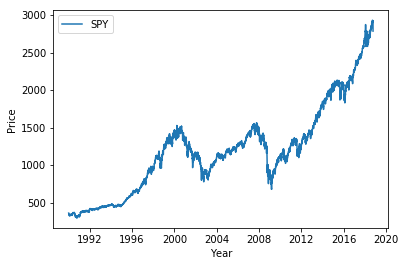

In [28]:
plt.plot(data.index, data['Adj Close'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['SPY'])
plt.show()

# Check for normal distribution
Have a look at the distribution of our price change

((array([-3.73039803, -3.50069273, -3.37436547, ...,  3.37436547,
          3.50069273,  3.73039803]),
  array([-0.09034978, -0.08929524, -0.08806776, ...,  0.07075755,
          0.10789006,  0.11580037])),
 (0.010541411804678429, 0.00034319177407760216, 0.9555978902748354))

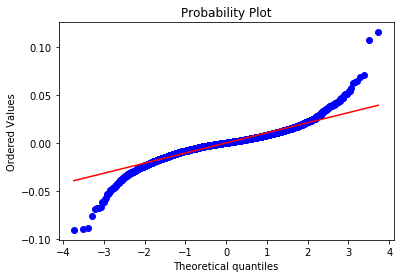

In [20]:
data['pct_chg'] = data['Adj Close'].pct_change()[1:]
data.dropna(inplace=True, axis=0)

stats.probplot(data['pct_chg'], dist="norm", plot=pylab)

# Log transformation
Though the target variable is not normally distributed, as long as the residuals are normally dis

((array([-3.73032853, -3.50061921, -3.37428954, ...,  3.37428954,
          3.50061921,  3.73032853]),
  array([-0.09469512, -0.09353652, -0.09218959, ...,  0.06836639,
          0.10245736,  0.10957197])),
 (0.010546093319435235, 0.00028393487268674845, 0.955194568394382))

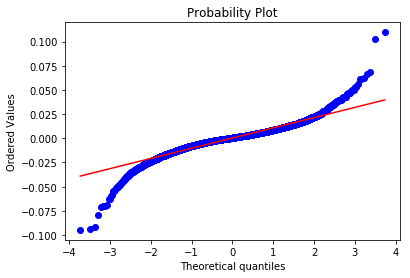

In [31]:
data['lrets'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.dropna(inplace=True, axis=0)
stats.probplot(data['lrets'], dist="norm", plot=pylab)

# Technical indicator 
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)

Similar code from https://github.com/alberduris/SirajsCodingChallenges/tree/master/Stock%20Market%20Prediction

# MACD: 

The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

In [11]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean() # Provides exponential weighted functions
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean() 
    
    MACD = EMA1-EMA2
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    return Histogram

# Stochastics oscillator: 

The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

In [12]:
def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

# Average True Range: 

Is an indicator to measure the volalitility (NOT price direction). The largest of:

Method A: Current High less the current Low
Method B: Current High less the previous Close (absolute value)
Method C: Current Low less the previous Close (absolute value)

Will use EGARCH to find volatility in the future

In [13]:
def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

# Combine it all

In [14]:
macd = MACD(data['Adj Close'], 12, 26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)
macd.tail()

Date
2018-10-02    -3.165455
2018-10-05    -5.849199
2018-10-08    -7.839346
2018-10-09    -9.479757
2018-10-10   -17.312894
dtype: float64

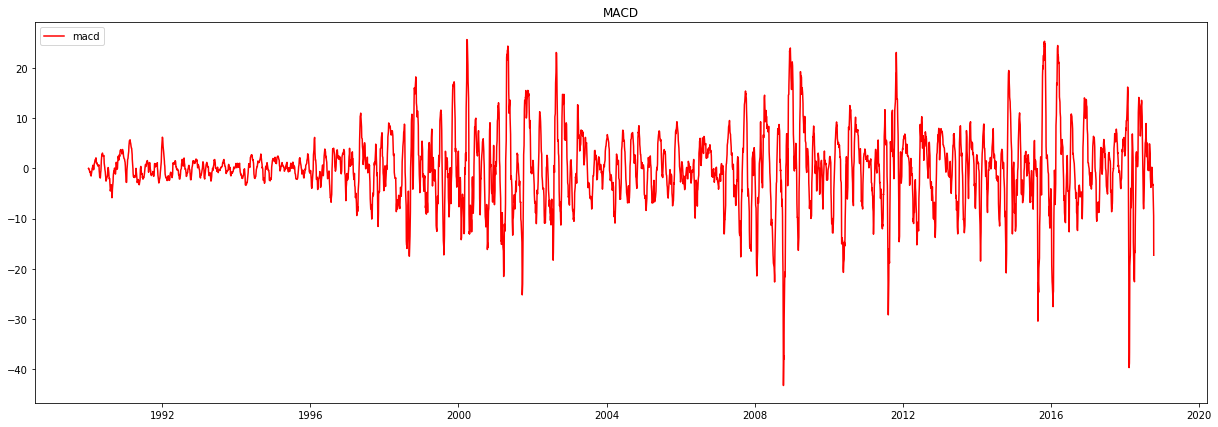

In [15]:
plt.figure(figsize=(21,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

In [16]:
stochastics = stochastics_oscillator(data['Adj Close'], 14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)
stochastics.tail()

Date
2018-10-02    82.921023
2018-10-05     0.000000
2018-10-08     0.000000
2018-10-09     0.000000
2018-10-10     0.000000
dtype: float64

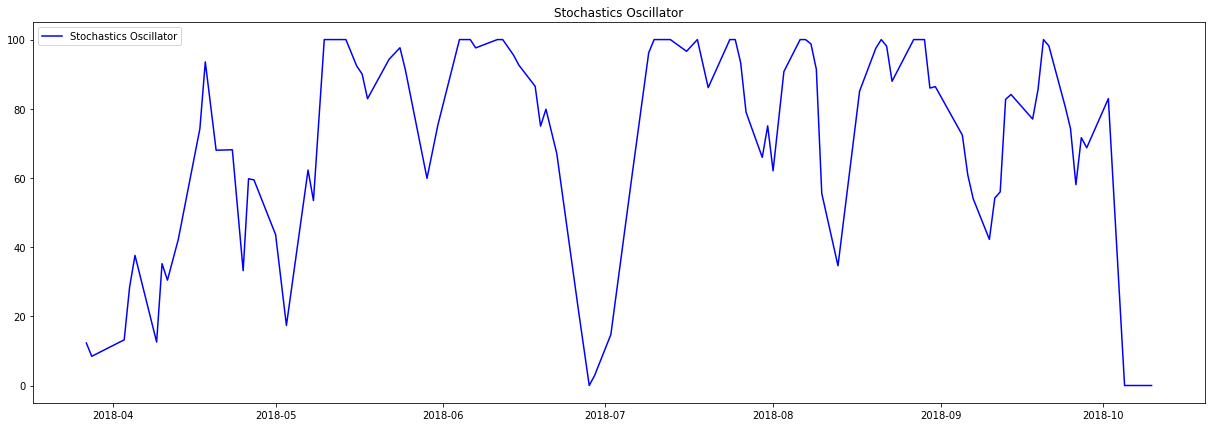

In [17]:
plt.figure(figsize=(21,7))
plt.plot(stochastics[-100:],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()

In [18]:
atr = ATR(data,14)
atr.rename(columns={0:'ATR'}, inplace=True)
atr.tail()

,ATR
Date,
2018-10-02,17.439942
2018-10-05,54.139893
2018-10-08,27.369873
2018-10-09,20.560058
2018-10-10,95.479981


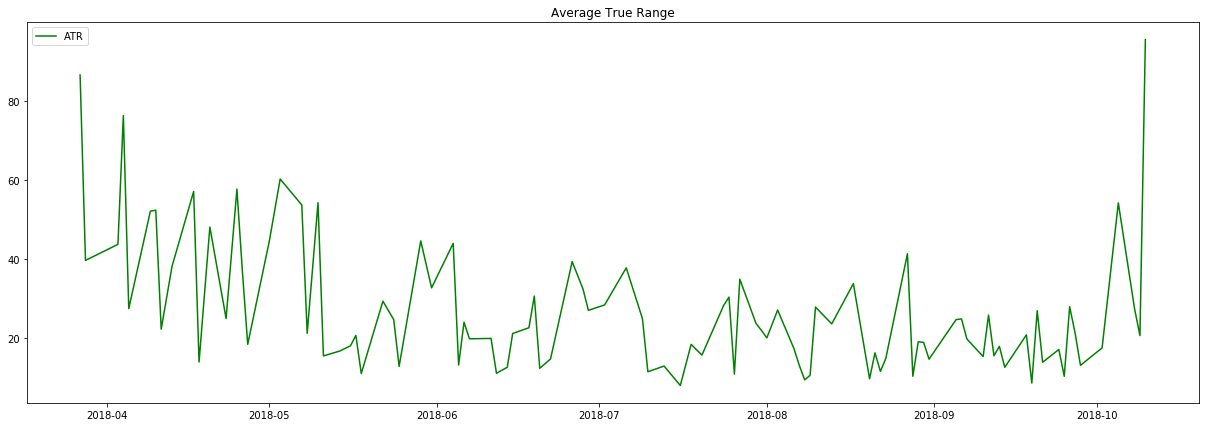

In [19]:
plt.figure(figsize=(21,7))
plt.plot(atr[-100:],label='ATR',color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

In [20]:
data = pd.concat([data, macd, stochastics, atr], axis=1)

In [21]:
data.rename(columns={0:'MACD', 1:'stochastics'}, inplace=True)

In [22]:
data.drop(['pct_chg', 'H-L', 'H-PC', 'L-PC'], axis=1 , inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,lrets,MACD,stochastics,ATR
Date,,,,,,,,,,
2018-10-02,2923.800049,2931.419922,2919.370117,2923.429932,2923.429932,3401880000,-0.000397,-3.165455,82.921023,17.439942
2018-10-05,2902.540039,2909.639893,2869.290039,2885.570068,2885.570068,3328980000,-0.005543,-5.849199,0.000000,54.139893
2018-10-08,2877.530029,2889.449951,2862.080078,2884.429932,2884.429932,3330320000,-0.000395,-7.839346,0.000000,27.369873
2018-10-09,2882.510010,2894.830078,2874.270020,2880.340088,2880.340088,3520500000,-0.001419,-9.479757,0.000000,20.560058
2018-10-10,2873.899902,2874.020020,2784.860107,2785.679932,2785.679932,4501250000,-0.033416,-17.312894,0.000000,95.479981


# Export it as HDF

In [25]:
data.to_hdf('technical500.h5', key='data')

In [11]:
#import matplotlib.pyplot as plt
#import pandas as pd
#import numpy as np 

#data = pd.read_hdf('technical500.h5', 'data')

#plt.figure(figsize=(21,7))
#plt.plot(data.index[-180:], np.expm1(data['lrets'][-180:]), color='red', label='Prediction')